In [ ]:
import datetime as dt
import pickle
import pandas as pd
import numpy as np
import os
import time
import sys
sys.path.append(os.getcwd())
from hawkes import dataLoader, inference, simulate, thinning_optimize #not importing fit because some error with tick installation
import matplotlib.pyplot as plt
np.random.seed(2)
np.set_printoptions(precision=17)
%matplotlib inline

# Generate Fake Data

## Create Fake Params

In [ ]:
mat = np.zeros((12,12))
for i in range(12):
    mat[i][i] = .6
for i in range(12):
    for j in range(12):
        if i == j: continue
        mat[i][j] = np.random.choice([1,-1])*mat[i][i]*np.exp(-.75*np.abs(j-i))

print(mat)
        
cols = ["lo_deep_Ask", "co_deep_Ask", "lo_top_Ask","co_top_Ask", "mo_Ask", "lo_inspread_Ask" ,
            "lo_inspread_Bid" , "mo_Bid", "co_top_Bid", "lo_top_Bid", "co_deep_Bid","lo_deep_Bid" ]

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(mat.transpose(), cmap='coolwarm')
fig.colorbar(im, cax=cax, orientation='vertical')
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(cols)), labels=[c +"->" for c in cols])
ax.set_yticks(np.arange(len(cols)), labels=cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cols)):
    for j in range(len(cols)):
        text = ax.text(i,j, np.round(mat[i][j], decimals=2),
                               ha="center", va="center")
# fig.savefig("heatmap.png")
# plt.show()


In [ ]:
# norm should be less than 1
np.max(np.linalg.eig(mat)[0])

In [ ]:
# create fake TOD params - 1.0 for now but can be changed to whatever you wish
faketod = {}
for k in cols:
    faketod[k] = {}
    for k1 in np.arange(13):
        faketod[k][k1] = 1.0
with open("fakeData_Params_sod_eod_dictTOD_constt", "wb") as f:
    pickle.dump(faketod, f)
    
# Create fake power law kernel params from the above norm matrix
paramsFake = {}
for i in range(12):
    paramsFake[cols[i]] = 0.1*np.random.choice([0.3,0.4,0.5,0.6,0.7])
    for j in range(12):
        maxTOD = np.max(list(faketod[cols[j]].values()))
        beta = np.random.choice([1.5,1.6,1.7,1.8,1.9])
        gamma = (1+np.random.rand())*5e3
        alpha = np.abs(mat[i][j])*gamma*(beta-1)/maxTOD
        paramsFake[cols[i]+"->"+cols[j]] = (np.sign(mat[i][j]), np.array([alpha, beta, gamma]))

mat = np.zeros((12,12))
for i in range(len(cols)):
    for j in range(len(cols)):
        kernelParams = paramsFake.get(cols[j]+"->"+cols[i], None)
        if kernelParams is None: continue
        mat[i][j] = kernelParams[0]*kernelParams[1][0]/((-1 + kernelParams[1][1])*kernelParams[1][2])


In [ ]:
# norm matrix from this fake power law kernels - does it match the above figure? - YES.
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(mat.transpose(), cmap='coolwarm')
fig.colorbar(im, cax=cax, orientation='vertical')
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(cols)), labels=[c +"->" for c in cols])
ax.set_yticks(np.arange(len(cols)), labels=cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cols)):
    for j in range(len(cols)):
        text = ax.text(i,j, np.round(mat[i][j], decimals=2),
                               ha="center", va="center")
# fig.savefig("heatmap.png")
plt.show()




In [ ]:
with open("fake_ParamsInferredWCutoff_sod_eod_true_optimize", "wb") as f:
    pickle.dump(paramsFake, f)

## Simulate Fake LOB Data

In [ ]:
#os.mkdir("./simulated_data")
faketod, fakeparams=thinning_optimize.preprocessdata(paramsPath="fake_ParamsInferredWCutoff_sod_eod_true_optimize", todPath="fakeData_Params_sod_eod_dictTOD_constt")
#print(fakeparams)

In [ ]:
#### WARNING: THIS PIECE OF CODE TAKES A LONG TIME ####
# orig_stdout=sys.stdout
# f = open('logging_optimized.txt', 'w')
# sys.stdout = f
thinningtime=0
np.random.seed(1)
start=time.perf_counter_ns()
for i in range(1):
    T, lob, lobL3, timefraction=thinning_optimize.simulate2(400, fakeparams, faketod, beta = 1., avgSpread = .01, spread0 = 5, price0 = 45)
    thinningtime+=timefraction
    with open("./simulated_data/fake_simulated_sod_eod_"+ str(i) , "wb") as f:
        pickle.dump((T, lob, lobL3), f)
    print("LOB ", i, ": ", lob)
end=time.perf_counter_ns()
# sys.stdout=orig_stdout
# f.close()
print("Simulation, took ", str((end-start)/10**9), "seconds.")
print("ThinningOgataIS_optimized took ", str(thinningtime/(10**9)), "seconds. ")
print("TimeFraction is: ", str(round(thinningtime*100/(end-start), 2)), "%. ")
#101.59251688753126

In [ ]:
# orig_stdout=sys.stdout
# f = open('logging.txt', 'w')
# sys.stdout = f
thinningtime=0
np.random.seed(1)
start=time.perf_counter_ns()
for i in range(1):
    T, lob, lobL3, timefraction=simulate.simulate(400, "fake_ParamsInferredWCutoff_sod_eod_true","fakeData_Params_sod_eod_dictTOD_constt" , beta = 1., avgSpread = .01, spread0 = 5, price0 = 45)
    thinningtime+=timefraction
    with open("./simulated_data/fake_simulated_sod_eod_"+ str(i) , "wb") as f:
        pickle.dump((T, lob, lobL3), f)
    print("LOB ", i, ": ", lob)
end=time.perf_counter_ns()
# sys.stdout=orig_stdout
# f.close()
print("Simulation, took ", str((end-start)/10**9), "seconds.")
print("ThinningOgataIS took ", str(thinningtime/(10**9)), "seconds. ")
print("TimeFraction is: ", str(round(thinningtime*100/(end-start), 2)), "%. ")

## Benchmarking

In [ ]:

t_max=20
Times=[j*100 for j in range(1, t_max+1)]
trials=5
res= np.zeros(shape=(trials+1, t_max, 3)) # res[trials][Timeperiod][optimized/nonoptimized][simulation, thinning, timefraction]
res2= np.zeros(shape=(trials+1, t_max, 3))
for i in range(1, trials+1):
    for Timeperiod in Times:
        np.random.seed(1)
        start=time.perf_counter_ns()
        T, lob, lobL3, timefraction=thinning_optimize.simulate2(Timeperiod, fakeparams, faketod, beta = 1., avgSpread = .01, spread0 = 5, price0 = 45)
        end=time.perf_counter_ns()
        res[i][Timeperiod//100 - 1][0]=abs(end-start)/10**9 + res[i-1][Timeperiod//100 - 1][0]
        res[i][Timeperiod//100 - 1][1]=abs(timefraction)/10**9 + res[i-1][Timeperiod//100 - 1][1]
        res[i][Timeperiod//100 - 1][2]=round(res[i][Timeperiod//100 - 1][1]/res[i][Timeperiod//100 - 1][0], 2) 
        np.random.seed(1)
        start=time.perf_counter_ns()
        T, lob, lobL3, timefraction=simulate.simulate(Timeperiod, "fake_ParamsInferredWCutoff_sod_eod_true","fakeData_Params_sod_eod_dictTOD_constt" , beta = 1., avgSpread = .01, spread0 = 5, price0 = 45)
        end=time.perf_counter_ns()
        res2[i][Timeperiod//100 - 1][0]=abs(end-start)/10**9 + res2[i-1][Timeperiod//100 - 1][0]
        res2[i][Timeperiod//100 - 1][1]=abs(timefraction)/10**9 + res2[i-1][Timeperiod//100 - 1][1]
        res2[i][Timeperiod//100 - 1][2]=round(res2[i][Timeperiod//100 - 1][1]/res2[i][Timeperiod//100 - 1][0], 2) 
        
        print("Done: (", i, ", ", Timeperiod, ")")

print("res: ", res)
print("res2: ", res2)


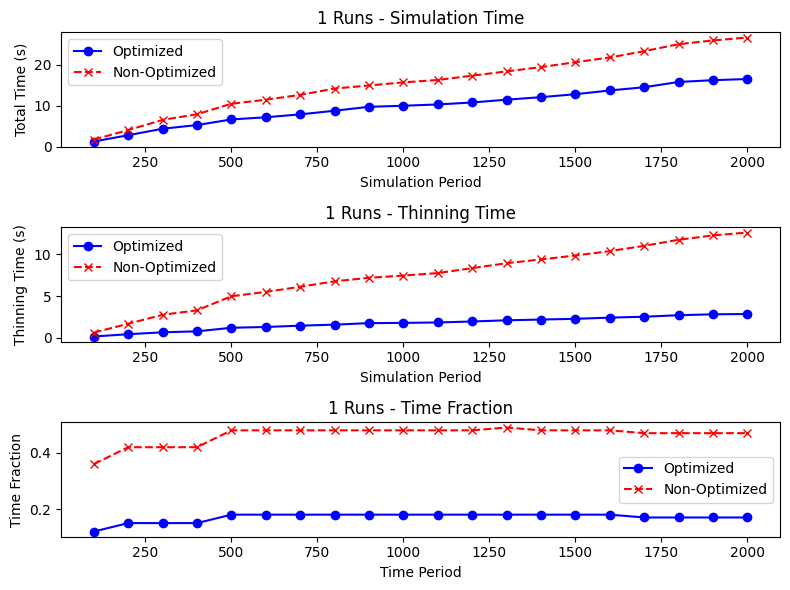

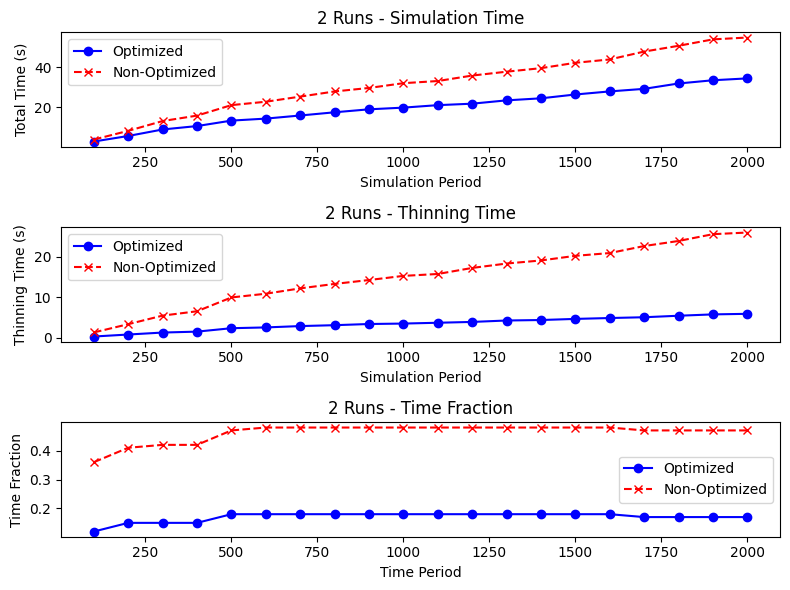

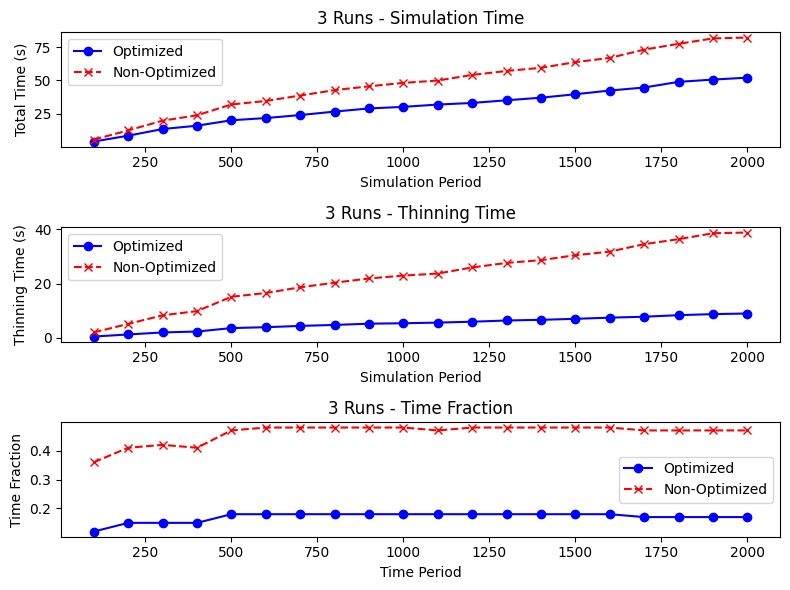

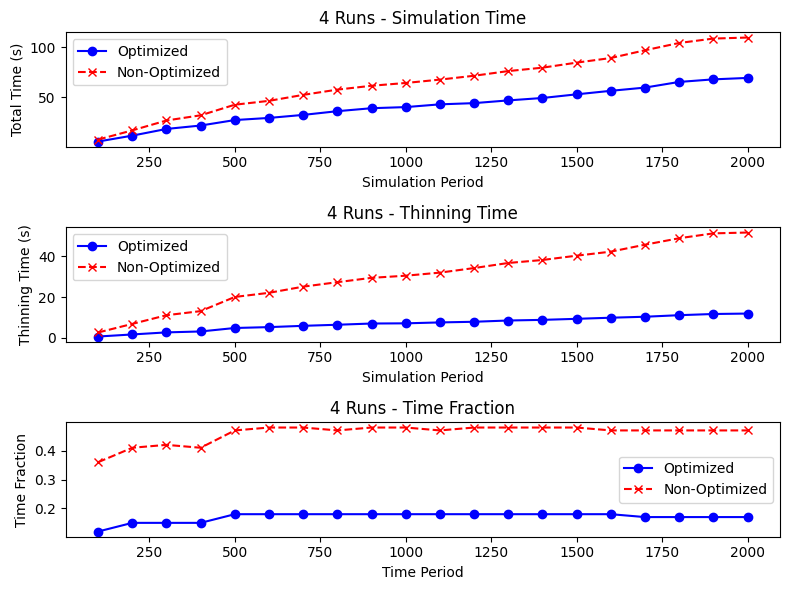

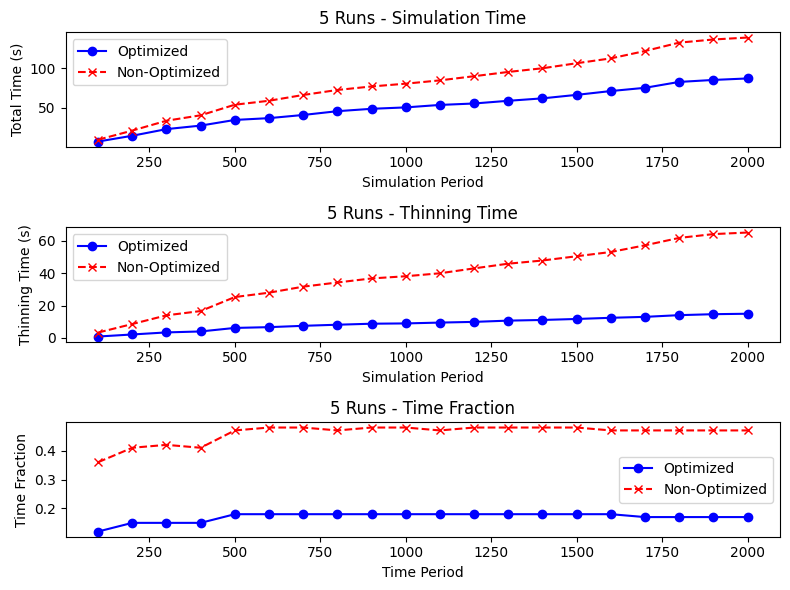

In [55]:
time_periods=np.arange(100, 2100, 100)
for trial in range(1, trials + 1):
    plt.figure(figsize=(8, 6))
    
    # Plot simulation time
    plt.subplot(3, 1, 1)
    plt.plot(time_periods, res[trial, :, 0], label='Optimized', color='blue', linestyle='-', marker='o')
    plt.plot(time_periods, res2[trial, :, 0], label='Non-Optimized', color='red', linestyle='--', marker='x')
    plt.title(f'{trial} Runs - Simulation Time')
    plt.xlabel('Simulation Period')
    plt.ylabel('Total Time (s)')
    plt.legend()

    # Plot thinning time
    plt.subplot(3, 1, 2)
    plt.plot(time_periods, res[trial, :, 1], label='Optimized', color='blue', linestyle='-', marker='o')
    plt.plot(time_periods, res2[trial, :, 1], label='Non-Optimized', color='red', linestyle='--', marker='x')
    plt.title(f'{trial} Runs - Thinning Time')
    plt.xlabel('Simulation Period')
    plt.ylabel('Thinning Time (s)')
    plt.legend()

    # Plot time fraction
    plt.subplot(3, 1, 3)
    plt.plot(time_periods, res[trial, :, 2], label='Optimized', color='blue', linestyle='-', marker='o')
    plt.plot(time_periods, res2[trial, :, 2], label='Non-Optimized', color='red', linestyle='--', marker='x')
    plt.title(f'{trial} Runs - Time Fraction')
    plt.xlabel('Time Period')
    plt.ylabel('Time Fraction')
    plt.legend()

    # Adjust layout and show the plot for the current trial
    plt.tight_layout()
    plt.show()

In [62]:
thinning_data = {
    'Time Period': time_periods,
    'Optimized Thinning Time(s)': [res[1, t, 1] for t in range(t_max)],
    'Thinning Time(s)': [res2[1, t, 1] for t in range(t_max)],
    'Runtime Improvement': [str(round((res2[1, t, 1]-res[1, t, 1])*100/res2[1, t, 1], 1))+"%" for t in range(t_max)]
}
df_thinning = pd.DataFrame(thinning_data)
df_thinning.set_index('Time Period', inplace=False)

# Create DataFrame for simulation time comparison
simulation_data = {
    'Time Period': time_periods,
    'Optimized Simulation Time(s)': [res[1, t, 0] for t in range(t_max)],
    'Simulation Time(s)': [res2[1, t, 0] for t in range(t_max)],
    'Runtime Improvement': [str(round((res2[1, t, 1]-res[1, t, 1])*100/res2[1, t, 0], 1))+"%" for t in range(t_max)]
}

df_simulation = pd.DataFrame(simulation_data)
df_simulation.set_index('Time Period', inplace=False)
print("Thinning Time Comparison:")
display(df_thinning)
print("\nSimulation Time Comparison:")
display(df_simulation)

Thinning Time Comparison:


,Time Period,Optimized Thinning Time(s),Thinning Time(s),Runtime Improvement
0,100,0.154586,0.630466,75.5%
1,200,0.434127,1.688564,74.3%
2,300,0.659404,2.763104,76.1%
3,400,0.778721,3.299666,76.4%
4,500,1.203073,4.988569,75.9%
5,600,1.301345,5.506268,76.4%
6,700,1.454016,6.122778,76.3%
7,800,1.582593,6.777986,76.7%
8,900,1.757530,7.200381,75.6%
9,1000,1.792417,7.471186,76.0%



Simulation Time Comparison:


,Time Period,Optimized Simulation Time(s),Simulation Time(s),Runtime Improvement
0,100,1.261008,1.747558,27.2%
1,200,2.802632,4.053018,31.0%
2,300,4.379007,6.543727,32.1%
3,400,5.280829,7.921373,31.8%
4,500,6.652074,10.482176,36.1%
5,600,7.175081,11.465662,36.7%
6,700,7.890223,12.640742,36.9%
7,800,8.774788,14.189727,36.6%
8,900,9.734137,14.941332,36.4%
9,1000,9.995368,15.700993,36.2%
